# Bulk analysis of constant velocity experiments
In this notebook we take a large number of constant velocity traces and inspect each of them for:
- Unfolding events
- Experimental errors
  - Multiple tethers
  - Bead loss

After which we determine the contour lengths of unfolded domains as well as their unfolding forces, by fitting each curve with Odijk and Marko-Siggia models (for DNA handles and unfolded protein respectively).

This is very much a work in progress and there are some things to keep in mind (also a todo/fix list):
- For now, fdcurves have to include both the pulling and relaxation parts, even if we only care about the pull.
- The error-finding capabilities are not yet proven to be effective.
- There is no error-handling and limited sanity-checking: the notebook can fail silently and in unexpected ways.

In [1]:
import lumicks.pylake as lk
import numpy as np
from matplotlib import pyplot as plt

from curve import Curve

## Defining models

Here we define our models. As long as the below estimates correspond, you should be able to change these. The name strings (```'handles'``` and ```'protein'```) feature as part of parameter names and these should stay consistent.

In [2]:
# these dont have to be build functions anymore, can just be model objects
def build_handles_model():
    return lk.inverted_odijk('handles') + lk.force_offset('handles')
def build_composite_model():
    comp_wrt_f = lk.odijk('handles') + lk.inverted_marko_siggia_simplified('protein')
    return comp_wrt_f.invert(interpolate = True, 
                             independent_min = 0,
                             independent_max = 90) + lk.force_offset('handles')

## Providing estimates

Here we provide some initial guesses for the model parameters in a dictionary format.

For each parameter, the possible entries are ```'value'```, ```'upper_bound'```, ```'lower_bound'``` and ```'fixed'```, where the latter fixes the parameter value to that in the 'value' field.

In [3]:
from build_config import bp2cl

handle_estimates = \
    {'handles/Lp':  # DNA handle persistence length (nm)
      {'value': 15,  # initial estimate
       'upper_bound': 100,  # very wide bounds?
       'lower_bound': 0.0},
     'handles/Lc':  # contour length (um)
      {'value': 0.3},#bp2cl(1040)},  # bp2cl generates a contour length from a number of basepairs.
     'handles/St':  # stretch modulus (pN)
      {'value': 300,
       'lower_bound': 250},
     'handles/f_offset':  # force offset (pN)
      {'value': 0,
       'upper_bound': 6,
       'lower_bound': -6,
       'fixed': True}  # if True, the parameter is fixed to the current 'value' field.
    }                 # here we use this entry to turn off the force offset included in the model
protein_estimates = \
     {'protein/Lp':  # unfolded protein persistence length (nm)
      {'value': 0.7,
      'upper_bound': 1.0,
      'lower_bound': 0.6,
      'fixed': False},
     'protein/Lc':  # contour length (um)
      {'value': 0.001,
       'fixed': False}
     }

## Providing data
To enter your data, replace the 'filename' fields with paths to your .h5 files, and include the names for your corresponding fdcurves in the list after 'curve_ids'. Each entry in the datasets list should look something like this:
```
{'filename' : 'PATH/TO/FILE.h5', 'curve_ids': ['CURVE1', 'CURVE2', 'CURVE3']}
```
Each fdcurve will be assigned a Curve object, which holds the force and distance data and has functions we will use to analyze the it.

We can use the ```PRUNE_ZEROS``` option below if we suspect datapoints with a distance measurement of zero or less. ```PREPEND_FILENAME``` determines if we prepend the origin filename to each curve id in order to enforce unique identifiers. Overlapping identifiers will result in only one of the affected fdcurves being analyzed.

From here the notebook should be able to run without user input.

In [4]:
# should add the option to include all fdcurves found in a file
datasets = [{'filename': '/home/kris/proj/.data/tweez/adk5_curve1.h5', 'curve_ids': ['adk5_curve1']},
            {'filename': '/home/kris/proj/.data/tweez/adk5_curve2.h5', 'curve_ids': ['adk5_curve2']},
            {'filename': '/home/kris/proj/.data/tweez/adk5_curve3.h5', 'curve_ids': ['adk5_curve3']}]
PRUNE_ZEROS = True
PREPEND_FILENAME = False

datasets = [{'filename': '20210302-190729 Marker 4_TrmD.h5'}]

In [5]:
fdcurves = {}
for dataset in datasets:
    data = lk.File(dataset['filename'])
    #print(data.fdcurves)
    for curve_id in dataset['curve_ids']:
        original = data.fdcurves[curve_id]
        fdata = data.fdcurves[curve_id].f.data
        ddata = data.fdcurves[curve_id].d.data
        if PRUNE_ZEROS:
            fdata = fdata[ddata > 0]
            ddata = ddata[ddata > 0]
        if PREPEND_FILENAME:
            curve_id = dataset['filename'] + ':' + curve_id
        fdcurves[curve_id] = Curve(curve_id, ddata, fdata)
        # we don't need the id in two different places

If for some reason you want to add simulated data, run this cell with ```DEBUG = True```. The simulations are a bit off. The arguments ```generate_fd``` takes are:
- the distance at which the first unfolding event happens
- a list containing unfolding domain contour lengths
- dna handle and protein parameter estimates in the same format as above

If you have any other sources of data, you can similarly include them by adding more Curve objects to the fdcurves dictionary. This would look like the following:
```
fdcurves[ID] = Curve(ID, DISTANCE_DATA, FORCE_DATA)
```

In [6]:
from simulate import generate_fd
DEBUG = False

if DEBUG:
    # multiple unfold cases
    dist_unfold = 0.38
    clslist = [[0.025], [0.015, 0.030], [0.01, 0.02, 0.03]]
    for index, cls in enumerate(clslist):
        curve_id = f'simulation_{index}'
        fdcurves[curve_id] = \
            Curve(curve_id, *generate_fd(dist_unfold, cls, handle_estimates, protein_estimates))
    # lost bead case
    dist, force = generate_fd(0.38, [0.025], handle_estimates, protein_estimates)
    force[1800:] = 0
    fdcurves['sim_loss'] = Curve('sim_loss', dist, force)

In [7]:
#with open('/home/kris/proj/.data/tweez/split_curves.csv', 'r') as f:
with open('/home/kris/proj/.data/tweez/full.csv', 'r') as f:
    rows = [line.split('\n')[0].split(',') for line in f]
    print(rows[0][0])
    print(np.asarray([float(x) for x in rows[0][1:]]))

curve_1_0ms
[0.07834779 0.07935793 0.07853191 ... 0.18135678 0.18660822 0.177863  ]


### Above data gets ignored. Here we take a big trace and split it up into separate curves.

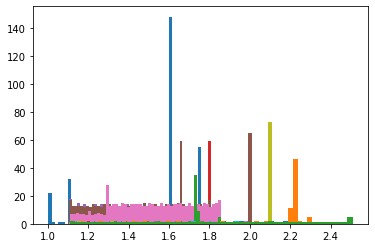

In [8]:
import h5py
from autosplit import autosplit

test_curves = autosplit('/home/kris/proj/.data/tweez/yhsp2.h5')
# pointless output

fdcurves = {}  # clear fdcurces
for key, curve in test_curves.items():
    fdcurves[key] = Curve(key, *[curve[dname]
                                for dname in ['full_dist', 'full_force',
                                              'pull_dist', 'pull_force',
                                              'rlx_dist', 'rlx_force']])

In [9]:
#import h5py
#fdcurves = {}
#with h5py.File('/home/kris/proj/.data/tweez/test.h5', 'r') as f:
#    for key, cdict in f.items():
#        fdcurves[key] = Curve(key, *[np.asarray(cdict[dname]) 
#                                     for dname in ['full_dist', 'full_force',
#                                                   'pull_dist', 'pull_force',
#                                                   'rlx_dist', 'rlx_force']])

## Bead loss errors
Data featuring force suddenly dropping to zero can dramatically slow down the event-finding and fitting steps, so we filter those out first. Other error-finding operations depend on the events found below and will happen later.

In [10]:
lost_bead_fdcurves = {}
for curve_id, curve in fdcurves.items():
    if curve.filter_bead_loss(handle_contour = handle_estimates['handles/Lc']['value']):
        lost_bead_fdcurves[curve_id] = curve
for curve_id in lost_bead_fdcurves.keys():
    print(curve_id)
    fdcurves.pop(curve_id)

curve_03
curve_53


## Event-finding
Here we try to find unfolding events, stationary/turning points and start-points. Unfolding events are recognized through a sharp dip in the force over time graph, and stationary/turning points by a sharp dip in the force's local variance. Start-points are determined by where the system's force first exceeds the ```STARTING_FORCE``` argument of the find_events function, which defaults to 0.

Curves are then split into 'legs' of datapoints between events, and those legs are used to fit our different models. The ```SHOW_PLOTS``` option produces a plot for each curve, showing the different events and legs.

Further (optional) arguments for the ```find_events``` function are:
- ```CORDON```, which determines how many datapoints directly before and after an event we exclude from fitting. Defaults to 10,
- ```FIT_ON_RETURN```, describes which part of the relaxation curve we mark for fitting. Defaults to an empty tuple, ignoring the relaxation curve. Valid input is a tuple like ```(WHEN, NUMBER)``` indicating how far after the return point to start fitting, and how many points to include.

```SHOW_PLOTS``` determines whether to show plots highlighting the different events and legs for each curve.

curve_02
curve_02
curve_04
curve_04
curve_05
curve_05
curve_06
curve_06
curve_07
curve_07
curve_08
curve_08
curve_09
curve_09
curve_10
curve_10
curve_11
curve_11
curve_12
curve_12
curve_13
curve_13
curve_18
curve_18
curve_19
curve_19
curve_20
curve_20
curve_21
curve_21
curve_22
curve_22
curve_23
curve_23
curve_24
curve_24
curve_25
curve_25
curve_26
curve_26
curve_27
curve_27


/home/kris/proj/tweez-CV/curve.py:124: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


curve_28
curve_28
curve_29
curve_29
curve_30
curve_30
curve_31
curve_31
curve_32
curve_32
curve_33
curve_33
curve_34
curve_34
curve_35
curve_35
curve_36
curve_36
curve_37
curve_37
curve_38
curve_38
curve_39
curve_39
curve_40
curve_40
curve_41
curve_41
curve_42
curve_42
curve_43
curve_43
curve_44
curve_44
curve_45
curve_45
curve_47
curve_47
curve_48
curve_48
curve_50
curve_50
curve_51
curve_51


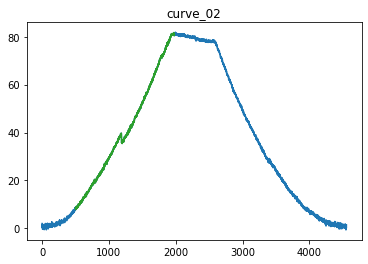

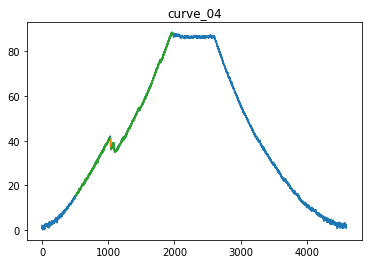

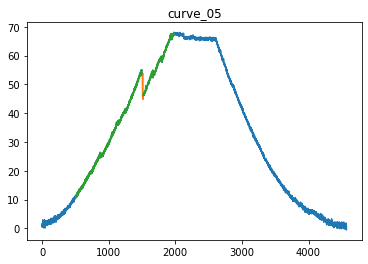

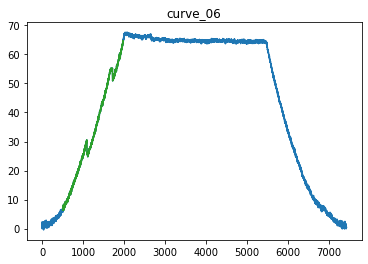

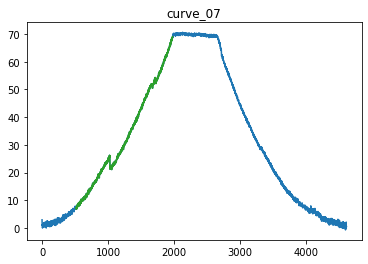

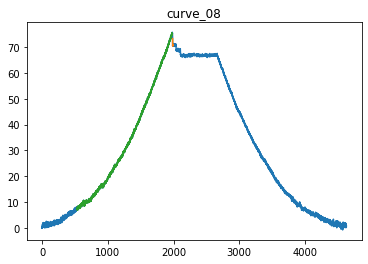

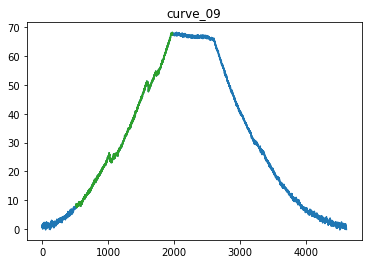

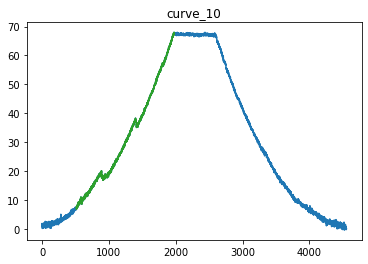

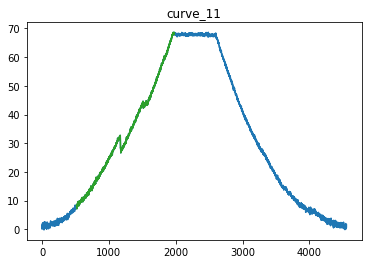

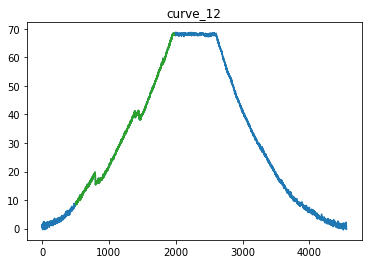

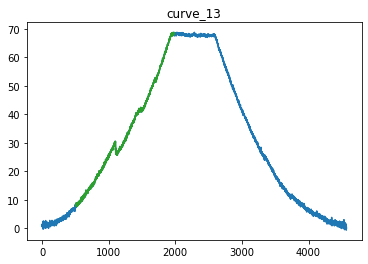

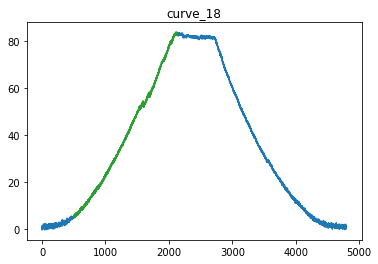

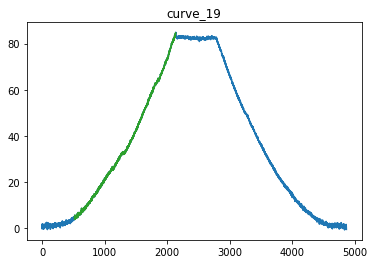

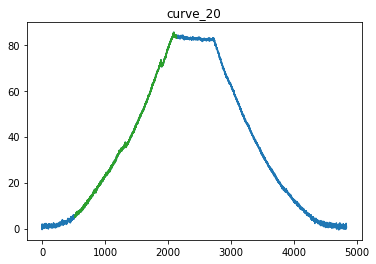

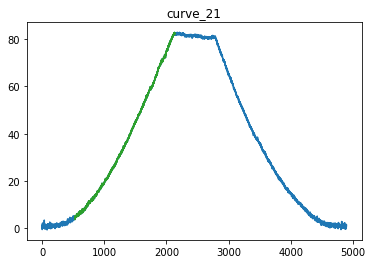

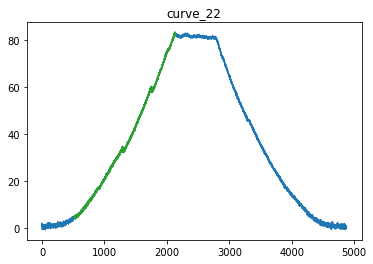

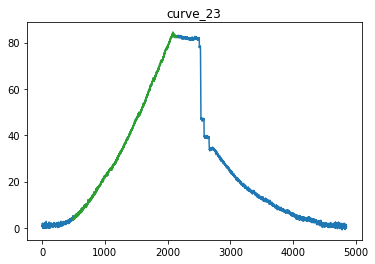

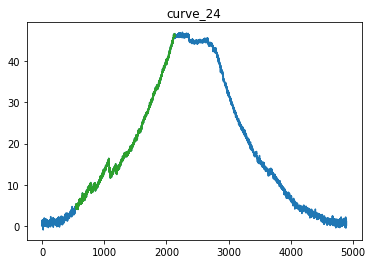

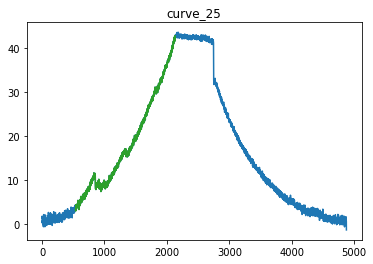

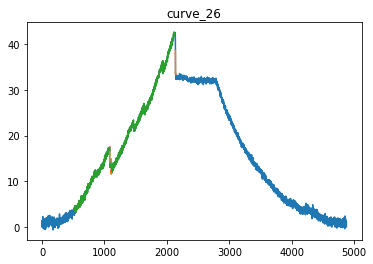

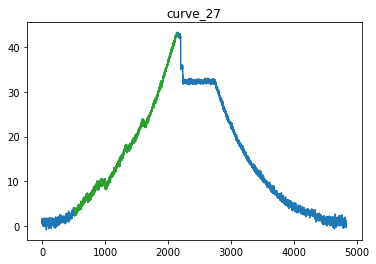

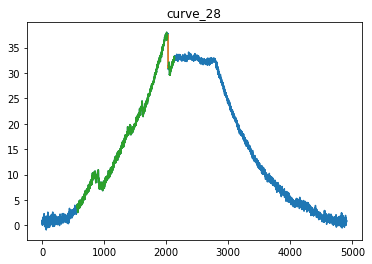

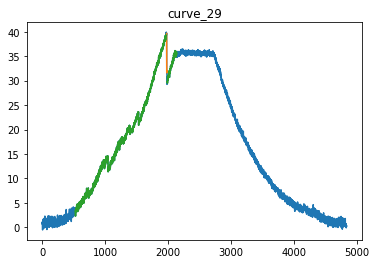

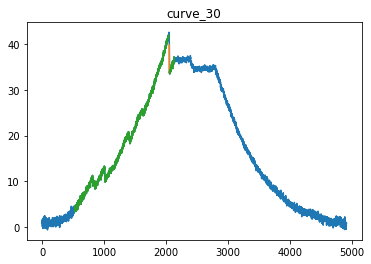

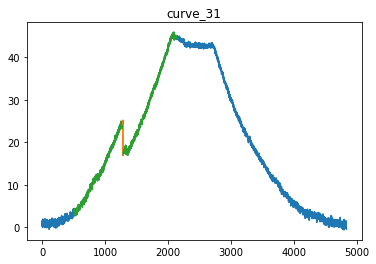

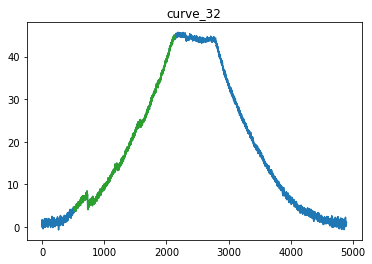

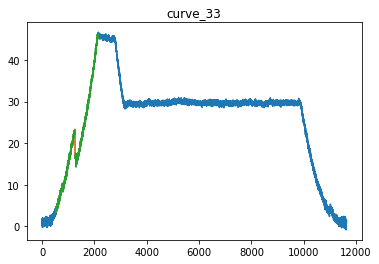

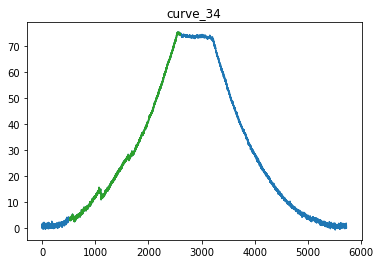

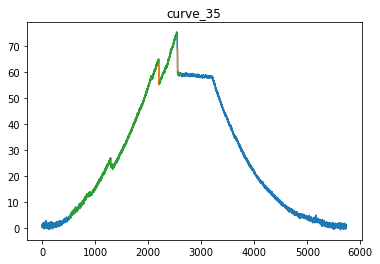

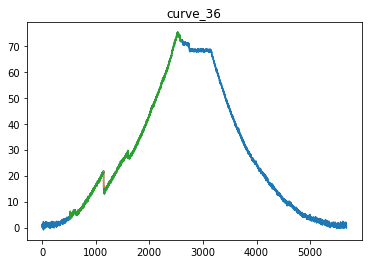

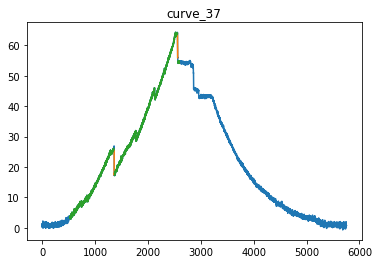

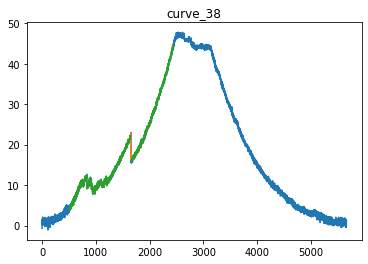

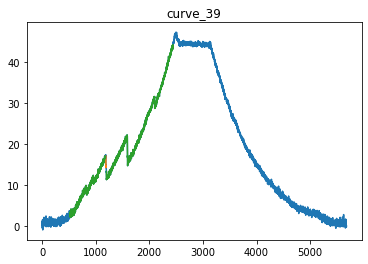

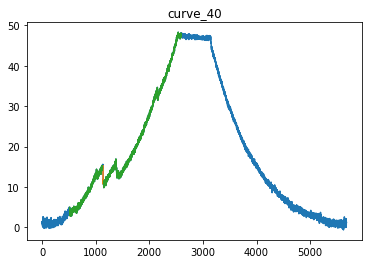

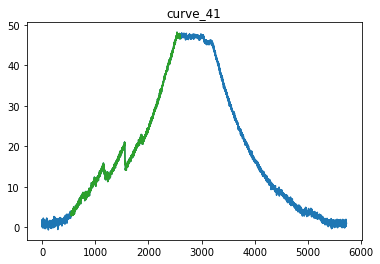

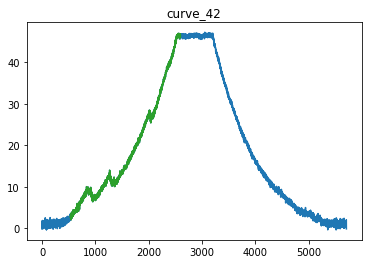

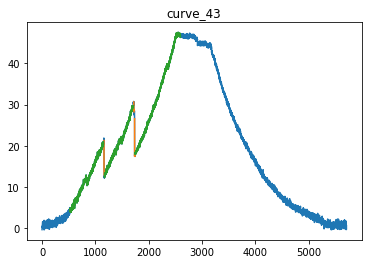

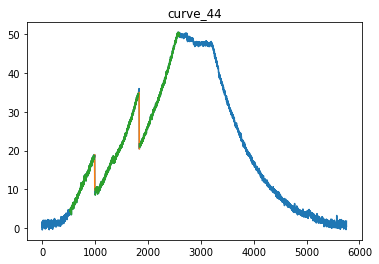

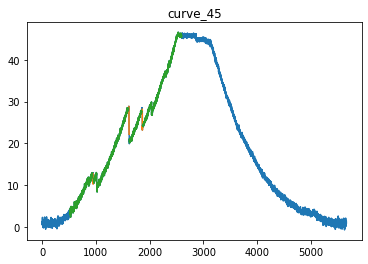

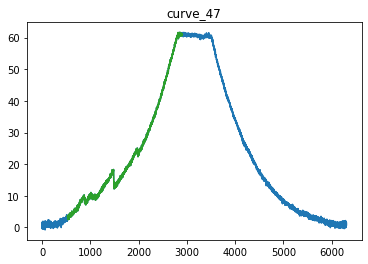

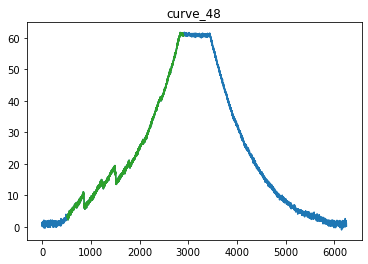

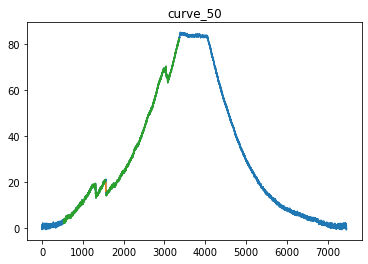

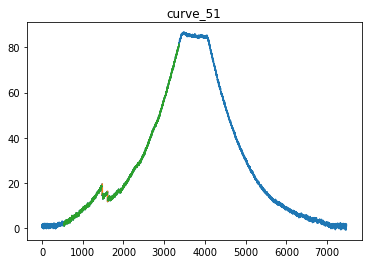

In [11]:
SHOW_PLOTS = True
%matplotlib inline

for curve in fdcurves.values():
    print(curve.identifier)
    curve.find_events(DEBUG=True, handle_contour = handle_estimates['handles/Lc']['value'])
    #print(curve.top)
    if SHOW_PLOTS:
        curve.plot_events()
# plot force over time (or number of measurements)
# green: fitted leg, orange: unfold event, red: return/stationary point


In [12]:
no_unfolds = {}
bad_legs = {}
for curve_id, curve in fdcurves.items():
    if not curve.unfolds.any(): #or not curve_id == 'split_curve9':
        no_unfolds[curve_id] = curve
    elif sum([leg.start > leg.stop for leg in curve.legs]) > 0:
        bad_legs[curve_id] = curve

print('no unfolds:')
for curve_id in no_unfolds.keys():
    print(curve_id)
    fdcurves.pop(curve_id)
print('bad legs:')
for curve_id in bad_legs.keys():
    print(curve_id)
    fdcurves.pop(curve_id)

no unfolds:
curve_02
curve_06
curve_07
curve_09
curve_10
curve_11
curve_12
curve_13
curve_18
curve_19
curve_20
curve_21
curve_22
curve_23
curve_24
curve_25
curve_27
curve_32
curve_34
curve_41
curve_42
curve_47
curve_48
bad legs:
curve_08
curve_26
curve_43


In [13]:
for curve_id, curve in fdcurves.items():
    print(curve_id)
    #print(curve.top)
    print(curve.unfolds)

curve_04
[1035]
curve_05
[1509]
curve_28
[2029]
curve_29
[1975]
curve_30
[2052]
curve_31
[1280]
curve_33
[1257]
curve_35
[2202 2553]
curve_36
[1148]
curve_37
[1363 2560]
curve_38
[1653]
curve_39
[1190]
curve_40
[1137]
curve_44
[ 994 1835]
curve_45
[ 948 1616 1864]
curve_50
[1563]
curve_51
[1479 1608]


## Error-finding
##### Multiple tethers
We filter multiple tethers comparison of the model as given in the estimates, with exaggerated parameters or data. The tests we perform include:
- A doubled persistence length
- A halved contour length
- Halved force data
- Doubled distance data

These should in theory test the single-tether case against the double-tether case. For a greater number of tethers we assume a double-tether model would fit better than a single-tether one. We compare the resulting BICs to determine pass or fail. We also compute Bayes factors for relative likelihood comparisons, but those turn out rather extreme.

Doubling the persistence length yields false positives and does not seem to be a good way to approximate a double tether. Some higher factor would probably work but for now we can just ignore that test.

We may want to hide some of this code behind an import

Halving contour length appears functionally identical to doubling the distance data, so we can do away with one.

In [14]:
from copy import deepcopy

original = handle_estimates
double_Lp = deepcopy(original)
half_Lc = deepcopy(original)
double_Lp['handles/Lp']['value'] = original['handles/Lp']['value'] * 2
half_Lc['handles/Lc']['value'] = original['handles/Lc']['value'] / 2

test_estimates = {'original': original, 'double_Lp': double_Lp, 
                  'half_Lc': half_Lc, 'half_force': original,
                  'double_dist': original}

for curve in fdcurves.values():
    print(curve.identifier)
    curve.filter_tethers(build_handles_model(), test_estimates)

curve_04
curve_04 
 {'half_Lc': False, 'double_dist': False, 'original': False, 'double_Lp': True, 'half_force': False}
curve_05
curve_05 
 {'half_Lc': False, 'double_dist': False, 'original': False, 'double_Lp': True, 'half_force': False}
curve_28
curve_28 
 {'half_Lc': False, 'double_dist': False, 'original': False, 'double_Lp': True, 'half_force': False}
curve_29
curve_29 
 {'half_Lc': False, 'double_dist': False, 'original': False, 'double_Lp': True, 'half_force': False}
curve_30
curve_30 
 {'half_Lc': False, 'double_dist': False, 'original': False, 'double_Lp': True, 'half_force': False}
curve_31
curve_31 
 {'half_Lc': False, 'double_dist': False, 'original': False, 'double_Lp': True, 'half_force': False}
curve_33
curve_33 
 {'half_Lc': False, 'double_dist': False, 'original': False, 'double_Lp': True, 'half_force': False}
curve_35
curve_35 
 {'half_Lc': False, 'double_dist': False, 'original': False, 'double_Lp': True, 'half_force': False}
curve_36
curve_36 
 {'half_Lc': False, '

## Fitting

Here we fit our models. We first define fits for each unfolding event, and proliferate a single fit of the DNA handles parameters to each of them. After that, we fit the remaining protein parameters with the legs we defined before. The third cell draws plots and shows parameter summaries for each curve.

In [15]:
for curve in fdcurves.values():
    print(curve.identifier, curve.legs)

curve_04 [slice(505, 1025, None), slice(1045, 1980, None)]
curve_05 [slice(502, 1499, None), slice(1519, 1980, None)]
curve_28 [slice(563, 2019, None), slice(2039, 2134, None)]
curve_29 [slice(526, 1965, None), slice(1985, 2134, None)]
curve_30 [slice(525, 2042, None), slice(2062, 2134, None)]
curve_31 [slice(511, 1270, None), slice(1290, 2134, None)]
curve_33 [slice(525, 1247, None), slice(1267, 2134, None)]
curve_35 [slice(519, 2192, None), slice(2212, 2543, None), slice(2563, 2596, None)]
curve_36 [slice(516, 1138, None), slice(1158, 2596, None)]
curve_37 [slice(529, 1353, None), slice(1373, 2550, None), slice(2570, 2596, None)]
curve_38 [slice(514, 1643, None), slice(1663, 2442, None)]
curve_39 [slice(516, 1180, None), slice(1200, 2442, None)]
curve_40 [slice(515, 1127, None), slice(1147, 2596, None)]
curve_44 [slice(533, 984, None), slice(1004, 1825, None), slice(1845, 2596, None)]
curve_45 [slice(519, 938, None), slice(958, 1606, None), slice(1626, 1854, None), slice(1874, 2596, 

In [16]:
for curve in fdcurves.values():
    print(curve.identifier)
    curve.initialize_fits(build_handles_model(),
                         build_composite_model(),
                         handle_estimates)

curve_04
curve_05
curve_28
curve_29
curve_30
curve_31
curve_33
curve_35
curve_36
curve_37
curve_38
curve_39
curve_40
curve_44
curve_45
curve_50
curve_51


In [17]:
# some fits may take a while. should finish though
for curve_id, curve in fdcurves.items():
    print(curve_id)
    curve.fit_composites(protein_estimates)

curve_04
curve_05
curve_28
curve_29
curve_30
curve_31
curve_33
curve_35
curve_36
curve_37
curve_38
curve_39
curve_40
curve_44
curve_45
curve_50
curve_51


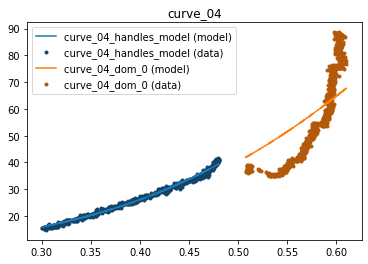

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp          0.196171   [nm]      False               0              100
handles/Lc          0.623919   [micron]  False               0              inf
handles/St        293.35       [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          1          [nm]      True                0.6              1
protein/Lc          0.0182187  [micron]  True                0              inf


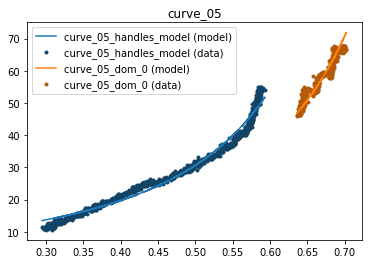

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp        0.168127     [nm]      False               0              100
handles/Lc        0.903627     [micron]  False               0              inf
handles/St        1.61389e+09  [pN]      False             250              inf
kT                4.11         [pN*nm]   False               0                8
handles/f_offset  0            [pN]      False              -6                6
protein/Lp        0.6          [nm]      True                0.6              1
protein/Lc        0.0735859    [micron]  True                0              inf


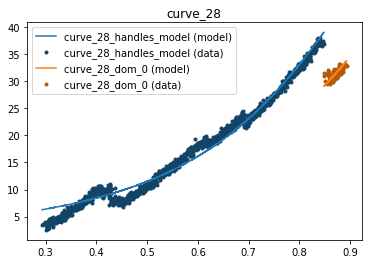

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.311527  [nm]      False               0              100
handles/Lc          0.979751  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.113918  [micron]  True                0              inf


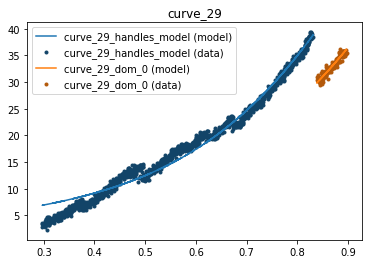

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.28388   [nm]      False               0              100
handles/Lc          0.97784   [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.113085  [micron]  True                0              inf


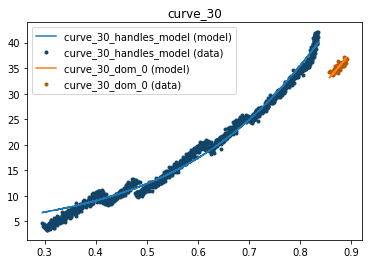

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.293067  [nm]      False               0              100
handles/Lc          0.966342  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.10088   [micron]  True                0              inf


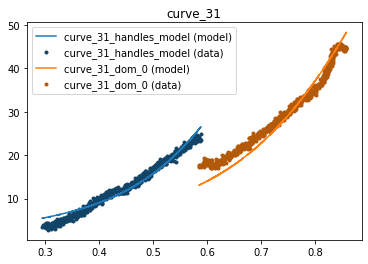

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.508677  [nm]      False               0              100
handles/Lc          0.70855   [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.195467  [micron]  True                0              inf


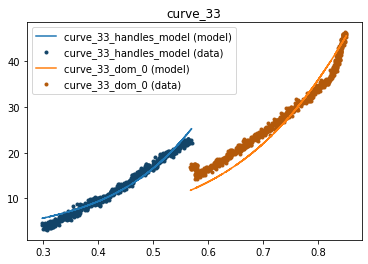

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.512397  [nm]      False               0              100
handles/Lc          0.696047  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.219417  [micron]  True                0              inf


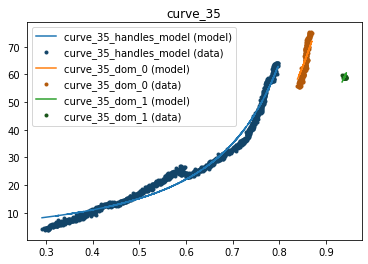

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp        0.233202     [nm]      False               0              100
handles/Lc        1.08401      [micron]  False               0              inf
handles/St        4.08682e+09  [pN]      False             250              inf
kT                4.11         [pN*nm]   False               0                8
handles/f_offset  0            [pN]      False              -6                6
protein/Lp        1            [nm]      True                0.6              1
protein/Lc        0.0607947    [micron]  True                0              inf
Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp        0.233202     [nm]      False         0                    100
handles/Lc        1.08401      [micron] 

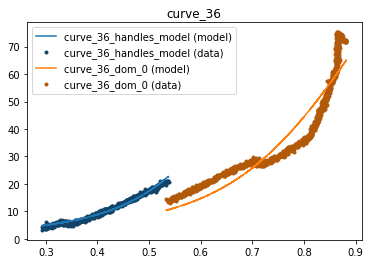

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.667727  [nm]      False               0              100
handles/Lc          0.647575  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.19866   [micron]  True                0              inf


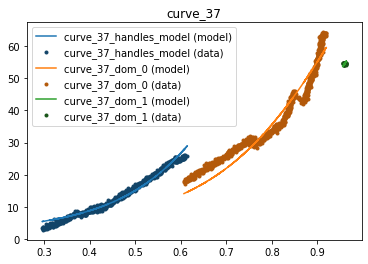

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.501301  [nm]      False               0              100
handles/Lc          0.722963  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.191954  [micron]  True                0              inf
Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.501301  [nm]      False          0                   100
handles/Lc          0.722963  [micron]  False       

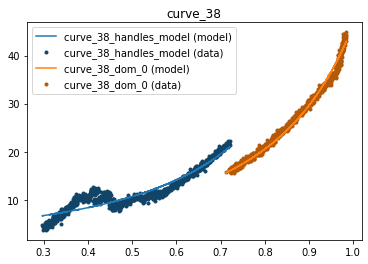

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp        0.261428     [nm]      False               0              100
handles/Lc        1.26986      [micron]  False               0              inf
handles/St        4.84138e+08  [pN]      False             250              inf
kT                4.11         [pN*nm]   False               0                8
handles/f_offset  0            [pN]      False              -6                6
protein/Lp        0.6          [nm]      True                0.6              1
protein/Lc        0.12459      [micron]  True                0              inf


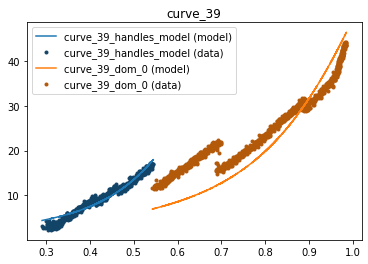

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.651102  [nm]      False               0              100
handles/Lc          0.702173  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.35248   [micron]  True                0              inf


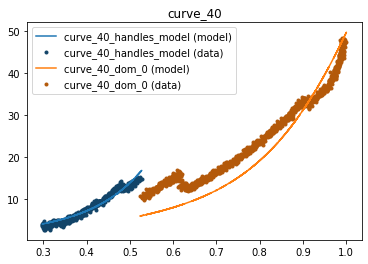

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.741314  [nm]      False               0              100
handles/Lc          0.675362  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.376638  [micron]  True                0              inf


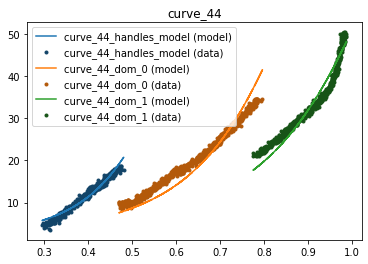

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.643056  [nm]      False               0              100
handles/Lc          0.59707   [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.276337  [micron]  True                0              inf
Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.643056  [nm]      False          0                   100
handles/Lc          0.59707   [micron]  False       

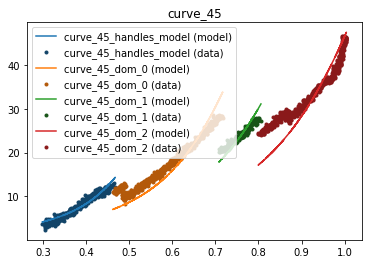

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.903719  [nm]      False               0              100
handles/Lc          0.602339  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.188376  [micron]  True                0              inf
Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.903719  [nm]      False          0                   100
handles/Lc          0.602339  [micron]  False       

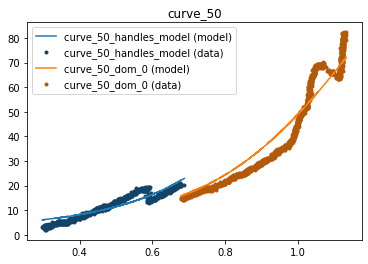

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.334339  [nm]      False               0              100
handles/Lc          0.948615  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          1         [nm]      True                0.6              1
protein/Lc          0.122589  [micron]  True                0              inf


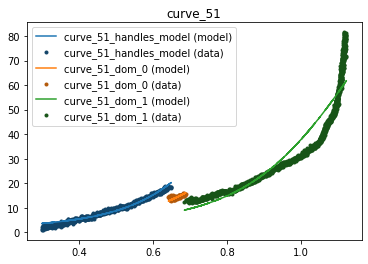

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.687182  [nm]      False               0              100
handles/Lc          0.801441  [micron]  False               0              inf
handles/St        250         [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          0.6       [nm]      True                0.6              1
protein/Lc          0.122552  [micron]  True                0              inf
Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp          0.687182  [nm]      False          0                   100
handles/Lc          0.801441  [micron]  False       

In [18]:
%matplotlib inline
for curve in fdcurves.values():
    curve.plot_fits()
    plt.yscale('linear')
    plt.show()
    curve.print_fit_params()

#### Computing unfolding forces
We compute the force for each unfolding event by simulating the fitted model to the distance slightly before the unfolding event. This part is lacking an error estimation.

In [19]:
for curve in fdcurves.values():
    curve.compute_unfold_forces(build_handles_model(), build_composite_model())

curve_04 
 [39.31279169755003]
curve_05 
 [52.629167437553406]
curve_28 
 [39.36002801783964]
curve_29 
 [38.54537903698979]
curve_30 
 [39.691630998107144]
curve_31 
 [26.4304634442429]
curve_33 
 [25.19892176625589]
curve_35 
 [60.81459391117096, 89.27866063788782]
curve_36 
 [22.35735474671961]
curve_37 
 [29.676440757504597, 58.86492172352039]
curve_38 
 [21.00507488846779]
curve_39 
 [18.6967794245611]
curve_40 
 [16.667205300474805]
curve_44 
 [21.27912851924241, 39.820520116595006]
curve_45 
 [13.934231046799844, 32.11878212154448, 30.70467754224982]
curve_50 
 [22.35515455978745]
curve_51 
 [20.037466445500414, 16.018690898847495]


#### Result summary table
Prints a summary table containing fitted contour length, persistence length and unfolding force for each unfolding domain. Could be prettier

In [20]:
# score and/or rank by fit quality

def get_avg_bic(curve_id, cid2):
    return fdcurves[curve_id].avg_bic() < fdcurves[cid2].avg_bic()

bics = [(key, curve.avg_bic()) for key, curve in fdcurves.items()]
bics.sort(key=lambda x: x[1])
print(bics)

# make a format string for the column widths
largest_id_len = max([len(id) for id in fdcurves.keys()])
row_format = f'{{:<{largest_id_len + 1}}}| {{:<5}}| {{:<9}}| {{:<9}}| {{:<9}}| {{}}'

print(row_format.format('Curve', 'fold', 'Lc (um)', 'Lp (nm)', 'Fu (pN)',
                        'failed tests'))
for (curve_id, bic) in bics:
    fdcurves[curve_id].print_result_rows(row_format)

if lost_bead_fdcurves:
    print('\nBead losses for curves', [curve_id for curve_id in
                                       lost_bead_fdcurves.keys()])

[('curve_45', 3971.652070858059), ('curve_30', 4994.487640215363), ('curve_44', 5047.549930215823), ('curve_28', 5208.932232040501), ('curve_29', 5565.401217219063), ('curve_37', 5984.147783853968), ('curve_05', 6057.462589516441), ('curve_38', 6156.698183941127), ('curve_31', 6479.642025540748), ('curve_33', 6683.014948663857), ('curve_35', 8664.97682921269), ('curve_51', 9564.20722154374), ('curve_04', 10511.80350270577), ('curve_39', 10750.452889901366), ('curve_40', 11071.60465802614), ('curve_36', 12580.305286663473), ('curve_50', 16594.871216268555)]
Curve    | fold | Lc (um)  | Lp (nm)  | Fu (pN)  | failed tests
curve_45 | 1    | 0.188376 | 0.6      | 13.9342  | ['double_Lp']
curve_45 | 2    | 0.135889 | 0.6      | 32.1188  | ['double_Lp']
curve_45 | 3    | 0.150321 | 0.6      | 30.7047  | ['double_Lp']
curve_30 | 1    | 0.10088  | 0.6      | 39.6916  | ['double_Lp']
curve_44 | 1    | 0.276337 | 0.6      | 21.2791  | ['double_Lp']
curve_44 | 2    | 0.201679 | 0.6      | 39.8205 

In [21]:
from event_finding import moving_window_SLR

In [22]:
models = moving_window_SLR(fdcurves['split_curve9'].force_data)

KeyError: 'split_curve9'

In [ ]:
models